-	Afstanden verblijfsobjecten met een woonfunctie (inclusief onderscheid huur en koop) naar afvalcontainers 
-	Afstanden verblijfsobjecten met een woonfunctie (verrijkt met BRP leeftijdscategorie 65+ plussers) naar afvalcontainers (BAG/BRP koppeling) 
-	Afstanden verblijfsobjecten met een woonfunctie (verrijkt met BRP leeftijdscategorie <=18 jaar) naar bibliotheken (BAG/BRP koppeling)
-	Afstanden verblijfsobjecten met een woonfunctie naar vestigingen supermarkten (zeg AH) 


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import geopandas as gpd
import shapely.speedups
shapely.speedups.enable()
from shapely import wkt, wkb
from shapely.geometry import Polygon, Point, LinearRing, MultiPoint
from shapely.ops import nearest_points
from tqdm import tqdm, tqdm_notebook

#helper functions
import sys
sys.path.insert(0, '../helper_functions/')
import wfs_processing as wfs
import get_tables as get
import distance_matrix as dm
from logger_settings import logger
logger = logger()

import yaml
with open("../config.yaml", 'r') as config_yml:
    try:
        yml = yaml.load(config_yml)
        for section in yml:
            print('sections in YAML : {}'.format(section))
    except yaml.YAMLError as exc:
        print (exc)

# interactive dropdown
import ipywidgets as widgets
fractie_choice = widgets.Dropdown(options=yml['afvalcontainers']['fracties'], value=None)

sections in YAML : path
sections in YAML : file
sections in YAML : file_stag_tables
sections in YAML : distance_matrix_files
sections in YAML : crs
sections in YAML : afvalcontainers
sections in YAML : dbscan_afvalcontainers
sections in YAML : dbscan_vot
sections in YAML : normen


In [143]:
import importlib
importlib.reload(dm)

<module 'distance_matrix' from '../helper_functions/distance_matrix.py'>

### loading poi tables

In [132]:
poi1 = get.get_stag_table_koop()

[14/Sep/2018 14:09:12] INFO - GeoDataFrame has shape: (64094, 9) and crs: {'init': 'epsg:28992'}


In [3]:
poi2 = get.get_afvalcontainers_df(column_subset=True, dbscan_clustering=True)

Fri, 14 Sep 2018 09:28:20 INFO     Clustered 12,293 afvalcontainers down to 5,596 inzamellocaties, for 54.48% compression in 8.34 sec.
Fri, 14 Sep 2018 09:28:20 INFO     Clustered GeoDataFrame has shape: (5596, 5) and crs: {'init': 'epsg:28992'}


In [91]:
print ('Choice your fractie')
fractie_choice

Choice your fractie


Dropdown(options=('Rest', 'Papier', 'Glas', 'Plastic', 'Textiel'), value=None)

In [159]:
fractie = fractie_choice.value 
buffer = yml['normen'][fractie]['kritiek_start']
bovengrens = yml['normen'][fractie]['bovengrens'] # value not according to distance norm

print ('fractie: {}'.format(fractie))
print ('buffer: {}'.format(buffer))
print ('bovengrens: {}'.format(bovengrens))

fractie: Textiel
buffer: 1500
bovengrens: 1501


In [160]:
stag_distance = dm.create_distance_matrix_afval(df1=poi1, df2=poi2, 
                                             fractie=fractie, 
                                             buffer = buffer, 
                                             include_nearest_point=False, 
                                             n=len(poi2))

[14/Sep/2018 15:42:47] INFO - Building dm (fractie: Textiel, buffer: 1500 with 5596 iterations


HBox(children=(IntProgress(value=0, max=165), HTML(value='')))

Shape sub_df 0 = (6269, 10)
Shape sub_df 1 = (6072, 10)
Shape sub_df 2 = (3709, 10)
Shape sub_df 3 = (7944, 10)
Shape sub_df 4 = (5382, 10)
Shape sub_df 5 = (4415, 10)
Shape sub_df 6 = (9461, 10)
Shape sub_df 7 = (4633, 10)
Shape sub_df 8 = (7794, 10)
Shape sub_df 9 = (3388, 10)
Shape sub_df 10 = (2949, 10)
Shape sub_df 11 = (3545, 10)
Shape sub_df 12 = (7949, 10)
Shape sub_df 13 = (7987, 10)
Shape sub_df 14 = (2005, 10)
Shape sub_df 15 = (3851, 10)
Shape sub_df 16 = (3535, 10)
Shape sub_df 17 = (4001, 10)
Shape sub_df 18 = (3163, 10)
Shape sub_df 19 = (3106, 10)
Shape sub_df 20 = (7964, 10)
Shape sub_df 21 = (3506, 10)
Shape sub_df 22 = (2023, 10)
Shape sub_df 23 = (7077, 10)
Shape sub_df 24 = (3170, 10)
Shape sub_df 25 = (2125, 10)
Shape sub_df 26 = (6675, 10)
Shape sub_df 27 = (4296, 10)
Shape sub_df 28 = (2529, 10)
Shape sub_df 29 = (1349, 10)
Shape sub_df 30 = (4031, 10)
Shape sub_df 31 = (6725, 10)
Shape sub_df 32 = (8847, 10)
Shape sub_df 33 = (4007, 10)
Shape sub_df 34 = (6636,

### Matrix needs deduplication

The above create_distance_matrix_afval fucntion creates distance calculations within a buffer distance around the `poi2` object (afvalcontainers in this case). It can happen, and frequently does that a verblijfsobject is within a buffer of multiple afvalcontainers. We then deduplicate the matrix by choosing the minimal distance (in combination with some other clean-up steps.

[14/Sep/2018 15:59:46] INFO - Raw dm has shape:(756145, 10)
[14/Sep/2018 15:59:46] INFO - Aggregated dm has shape:(64094, 9)
[14/Sep/2018 15:59:46] INFO - merge results:
both          63029
left_only      1065
right_only        0
Name: _merge, dtype: int64
[14/Sep/2018 15:59:46] INFO - Filled values above the 1500 norm with bovengrens value: 1501
[14/Sep/2018 15:59:47] INFO - Final dm has shape:(64094, 10)
[14/Sep/2018 15:59:47] INFO - columns dm ['landelijk_vot_id', 'landelijk_pnd_id', 'geometry', 'geom_point', 'cluster_toewijzing', 'distance_min', 'distance_max', 'distance_mean', '_merge', 'pnd_dist_mean']
histogram numerical distance columns: 


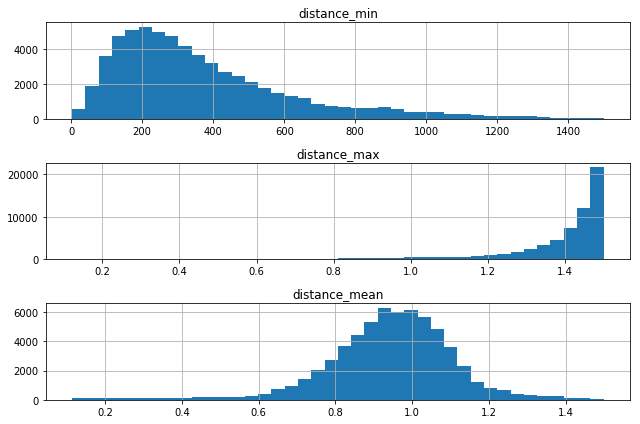

In [161]:
final = dm.deduplicate_distance_matrix_afval(stag_distance, 
                                             df1=poi1, 
                                             buffer = buffer,
                                             bovengrens=bovengrens)

### to csv

In [162]:
final.to_csv(yml['path']['distance_matrices'] + 'distance_koop_' + fractie + '.csv', index=False)